In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
import yaml 
import glob 
import pandas as pd
from burst import *

class LabelAnalysis():

    def __init__(self, video_name):
        self.video_name = video_name 
        self.__path = r'C:\Users\jyc13\Documents\Python Scripts\openCV_eyemovement\yolov5\runs\detect\{0}\labels'.format(video_name)
        self.__object_classes = yaml.safe_load(open('object_classes.yaml', 'r'))
        self.read_video_info()
        self.check_video_name()

        self.__video_w = int(self.this_info['FrameWidth']) # 가로 resolution
        self.__video_h = int(self.this_info['FrameHeight']) # 세로 resolution
        self.__video_fps = float(self.this_info['FPS']) # frame per second
        self.__start_frame = int(self.this_info['StartFrame'])
        self.__end_frame = int(self.this_info['EndFrame'])
        # need to update
        # self.__pixelpermm = 10.2 # pixel/mm 

    def read_video_info(self):
        file_path = "D:\Research\SC\DATA\Eye_Movement\VideoInfo.csv"
        self.video_info = pd.read_csv(file_path)
    
    def check_video_name(self):
        _this_info = self.video_info[self.video_info['Frequency'] == 20]
        _this_video_names = _this_info['VideoName']
        if (_this_video_names.str.contains(self.video_name).any()) == True:
            print(f"{self.video_name} is found.")
            self.this_info = self.video_info.loc[self.video_info['VideoName'] == self.video_name, :]
        else: 
            raise Exception(f"There is no file named {self.video_name}.")

    def read_labels(self):
        # YOLO style: (num_class center_x center_y w, h \n) 모든 값은 resoluion 기준으로 비율
        
        # read all txt files in the __path
        files = glob.glob(f'{self.__path}/*.txt')
        data = []
        for file in files:
            n_frame = int(file.split('_')[-1].replace('.txt', ''))
            if (n_frame >= self.__start_frame) & (n_frame <= self.__end_frame):
                with open(file, 'rt') as f:
                    lines = f.readlines()
                    for line in lines:
                        splited = line.split(' ')
                        num_class = int(splited[0])
                        class_name = str(self.__object_classes[num_class])
                        # pixel 단위로 변환
                        center_x = float(splited[1]) * self.__video_w 
                        center_y = float(splited[2]) * self.__video_h 
                        w = float(splited[3]) * self.__video_w 
                        h = float(splited[4]) * self.__video_h 
                        size = w * h # size는 width * height 직사각형이라고 가정

                        frame_data = [n_frame, num_class, class_name, center_x, center_y, w, h, size]
                        data.append(frame_data)
            else:
                pass 

        # format Dataframe
        df = pd.DataFrame(data)
        df.rename(columns = {0:'n_frame'}, inplace = True)
        df.rename(columns = {1:'num_class'}, inplace = True)
        df.rename(columns = {2:'class_name'}, inplace = True)
        df.rename(columns = {3:'center_x'}, inplace = True)
        df.rename(columns = {4:'center_y'}, inplace = True)
        df.rename(columns = {5:'width'}, inplace = True)
        df.rename(columns = {6:'height'}, inplace = True)
        df.rename(columns = {7:'size'}, inplace = True)

        df.sort_values(by=['n_frame', 'num_class'], inplace=True, ignore_index=True)

        # interpolation
        # df['center_x_intp'] = df.groupby(by=['class_name'])['center_x'].apply(lambda group: group.interpolate(method='n_frame'))

        # diff
        df['pupil-eye_x'] = df.groupby(by=['n_frame'])['center_x'].diff()
        df['pupil-eye_y'] = df.groupby(by=['n_frame'])['center_y'].diff()

        # Time code
        df['time_code'] = df['n_frame'] / self.__video_fps # return time code

        return df 
    
    def get_onoff(self):
        mouse = Burst(video_name=self.video_name)
        df_onoff = mouse.get_stim_on_frames()

        return df_onoff

    def merge_df(self):
        df_base = self.read_labels()
        df_onoff = self.get_onoff()
        df_merge = df_base.merge(df_onoff, on=['n_frame'])

        return df_merge

    def get_result_df(self):
        df_res = self.merge_df()

        return df_res
    
    def get_stim_range_list(self):
        df_res = self.merge_df()

        range_list = []
        prev_val = False

        for inx, val in df_res['stim'].iteritems():
            if prev_val != val:
                if val:
                    start = df_res.loc[inx, 'n_frame']
                else:
                    range_list.append((start, df_res.loc[inx, 'n_frame']))

            prev_val = val
            
        return range_list

In [3]:
detect_path = r'C:\Users\jyc13\Documents\Python Scripts\openCV_eyemovement\yolov5\runs\detect'
l_20_filenames = [x for x in os.listdir(detect_path) if 'L 20hz' in x]
r_20_filenames = [x for x in os.listdir(detect_path) if 'R 20hz' in x]
print(len(l_20_filenames), len(r_20_filenames))

12 12


In [75]:
video1_name = '34 L 20hz 5ms 5s.mp4'
mouse1 = LabelAnalysis(video_name=video1_name)

res_df = mouse1.get_result_df()
display(res_df.isna().sum())

34 L 20hz 5ms 5s.mp4 is found.
34 L 20hz 5ms 5s.mp4 is found.


n_frame            0
num_class          0
class_name         0
center_x           0
center_y           0
width              0
height             0
size               0
pupil-eye_x    16978
pupil-eye_y    16978
time_code          0
stim               0
dtype: int64

In [103]:
range_list = mouse1.get_stim_range_list()
print(f'num stim cycles: {len(range_list)}')

34 L 20hz 5ms 5s.mp4 is found.
29 [(1, 43), (342, 641), (940, 1239), (1538, 1837), (2136, 2435), (2734, 3033), (3332, 3631), (3930, 4229), (4528, 4827), (5126, 5425), (5724, 6023), (6322, 6621), (6920, 7219), (7518, 7817), (8116, 8415), (8714, 9013), (9312, 9611), (9910, 10209), (10508, 10807), (11106, 11405), (11704, 12003), (12302, 12601), (12900, 13199), (13498, 13797), (14096, 14395), (14694, 14993), (15292, 15591), (15890, 16189), (16488, 16787)]


In [109]:
x_span = 180
peth = []
n_cycle = 0

for (start, end) in range_list:
    if (start >= x_span) & (end <= max(res_df['n_frame']) - x_span):
        tmp = res_df.copy()
        tmp['peth_frame'] = tmp['n_frame'] - start
        tmp = tmp.loc[(tmp['peth_frame'] >= -x_span) & (tmp['peth_frame'] <= x_span)]
        tmp.loc[:, 'n_cycle'] = n_cycle
        n_cycle += 1
        peth.append(tmp)

df_peth = pd.concat(peth)
display(df_peth)

,n_frame,num_class,class_name,center_x,center_y,width,height,size,pupil-eye_x,pupil-eye_y,time_code,stim,peth_frame,n_cycle
322,162,0,eye,794.49984,535.99968,132.999936,108.000000,14363.993088,NaN,NaN,2.702703,False,-180,0
323,162,1,pupil,787.00032,543.00024,93.999936,85.999968,8083.991488,-7.49952,7.00056,2.702703,False,-180,0
324,163,0,eye,795.99936,534.99960,134.000064,105.999948,14203.999816,NaN,NaN,2.719386,False,-179,0
325,163,1,pupil,788.00064,543.00024,93.999936,85.999968,8083.991488,-7.99872,8.00064,2.719386,False,-179,0
326,164,0,eye,795.50016,535.49964,135.000000,104.999976,14174.996760,NaN,NaN,2.736069,False,-178,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33267,16666,1,pupil,784.50048,536.99976,87.000000,80.000028,6960.002436,-11.49888,4.99932,278.044711,True,178,27
33268,16667,0,eye,795.99936,531.50040,132.000000,100.999980,13331.997360,NaN,NaN,278.061395,True,179,27
33269,16667,1,pupil,784.50048,537.49980,87.000000,81.000000,7047.000000,-11.49888,5.99940,278.061395,True,179,27
33270,16668,0,eye,795.99936,531.50040,132.000000,99.000036,13068.004752,NaN,NaN,278.078078,True,180,27


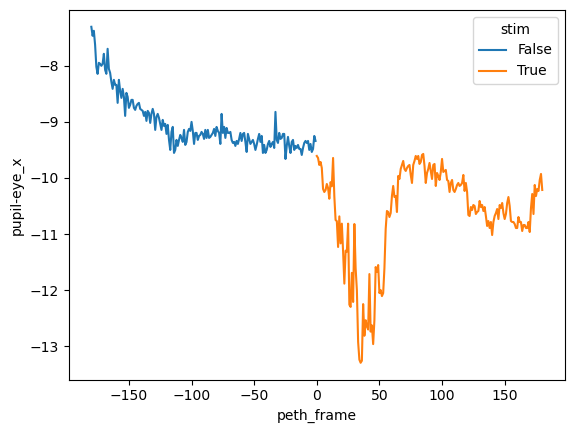

In [111]:
# PETH 
df_plot = df_peth.dropna()
display(df_plot)
sns.lineplot(x='peth_frame', y='pupil-eye_x', hue='stim', data=df_plot) # std span 보기 위해
plt.show()


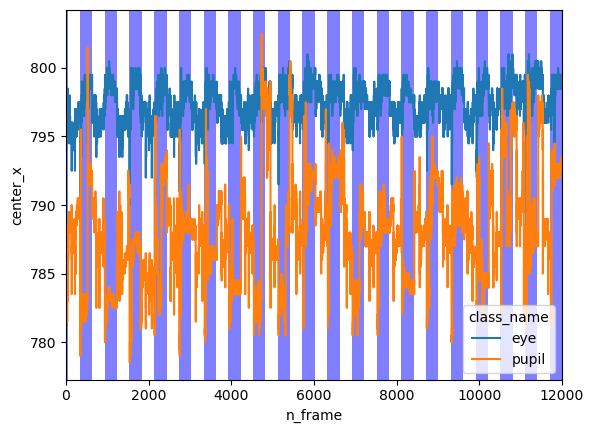

In [79]:
# x-axis
sns.lineplot(x='n_frame', y='center_x', hue='class_name', data=res_df)

for (start, end) in range_list:
    plt.axvspan(start, end, facecolor='blue', alpha=0.5)

plt.xlim(0, 12000)
plt.show()

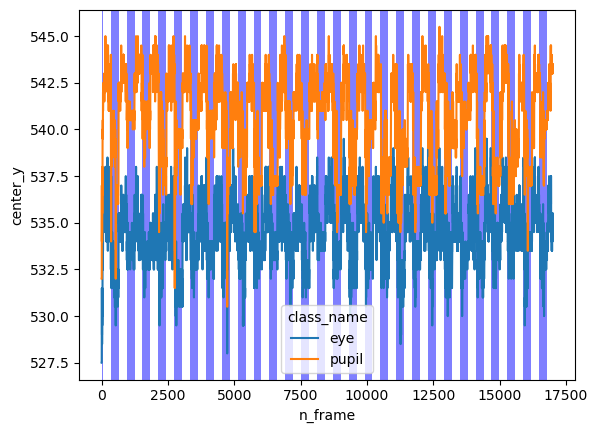

In [80]:
# y-axis
sns.lineplot(x='n_frame', y='center_y', hue='class_name', data=res_df)
for (start, end) in range_list:
    plt.axvspan(start, end, facecolor='blue', alpha=0.5)
plt.show()

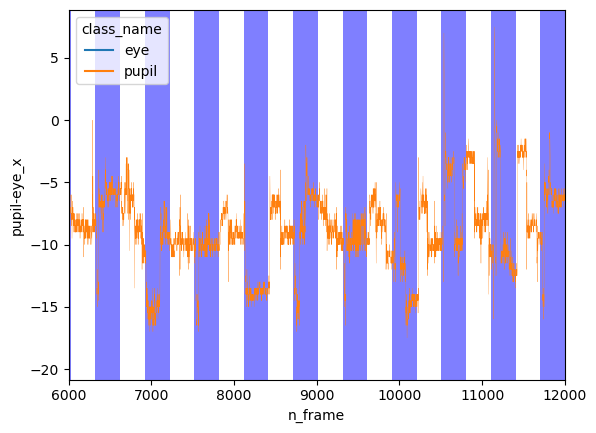

In [81]:
# diff_x
sns.lineplot(x='n_frame', y='pupil-eye_x', hue='class_name', data=res_df, linewidth=0.2)
for (start, end) in range_list:
    plt.axvspan(start, end, facecolor='blue', alpha=0.5)

plt.xlim(6000, 12000)
plt.show()

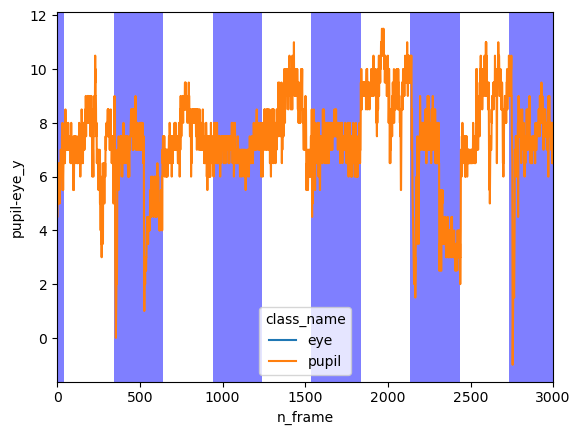

In [82]:
# diff_y
sns.lineplot(x='n_frame', y='pupil-eye_y', hue='class_name', data=res_df)
for (start, end) in range_list:
    plt.axvspan(start, end, facecolor='blue', alpha=0.5)

plt.xlim(0, 3000)
plt.show()